In [94]:
import matplotlib.pyplot as plt # for plotting maps
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
from statistics import mean, median
from functools import reduce
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

DATA_PATH = "raw-from-source/"

# From the SoS site
DEM_VOTES = 1803362 
REP_VOTES = 1282804
TOTAL_VOTES_CAST = DEM_VOTES + REP_VOTES

### This notebook was used to figure out the merging and precinct assignments that took place in VEST's 2018 WA dataset. It does not deserve review, all of the relevant information can be found in the final cells of VEST-wa-2018-validation.ipynb. 

In [95]:
master_shape_df = gp.read_file(DATA_PATH + "SoS-2018-general-data/2018Precinct_VERIFIED/2018Precincts_VERIFIED.shp")
master_election_df = pd.read_csv(DATA_PATH + "direct-download/20181106_allstateprecincts.csv")
master_partner_df = gp.read_file(DATA_PATH + "VEST-wa-data/wa_2018.shp")
master_ok_df = gp.read_file(DATA_PATH + "SoS-2018-general-data/2018Precincts_OK_Consol/2018Precincts_OK_Consol.shp")

In [96]:
sdf = master_shape_df.copy()
edf = master_election_df.copy()
vdf = master_partner_df.copy()
okdf = master_ok_df.copy()


edf = edf[edf["Race"] == "U.S. Senator"]

In [97]:
sdf = sdf[sdf["CountyCd"] == "OK"]
edf = edf[edf["CountyCode"] == "OK"]
edf = edf[edf["PrecinctCode"] != -1]
okdf = okdf[okdf["CountyCd"] == "OK"]
vdf = vdf[vdf["COUNTYCD"].isin(["OK", "OKC"])]
print(len(sdf))
print(len(edf))
print(len(okdf))
print(len(vdf))

248
448
223
223


In [98]:
# Let's look at the precinct values
prcs_s = sdf["PrcCode"].unique()
prcs_e = edf["PrecinctCode"].astype('str').unique()
prcs_v = vdf["PRCCODE"].unique()
prcs_ok = okdf["PrcCode"].unique()

unique_s = [p for p in prcs_s if p not in prcs_e and p not in prcs_v and p not in prcs_ok]
print(unique_s)

unique_e = [p for p in prcs_e if p not in prcs_s and p not in prcs_v and p not in prcs_ok]
print(unique_e)

unique_v = [p for p in prcs_v if p not in prcs_s and p not in prcs_e and p not in prcs_ok]
print(unique_v)

unique_ok = [p for p in prcs_ok if p not in prcs_s and p not in prcs_e and p not in prcs_v]
print(unique_v)

# Let's see if VEST uses the OK consolidated precincts
print(len(prcs_ok[prcs_ok == prcs_v]) == len(prcs_ok)) 

# Let's see if the precincts match between ok_df and shape_df outside of OK
print(master_ok_df[~master_ok_df["PrcCode"].isin(master_partner_df["PRCCODE"])])
print(master_partner_df[~master_partner_df["PRCCODE"].isin(master_ok_df["PrcCode"])])
print(master_ok_df[~master_ok_df["FullPrc"].isin(master_partner_df["FULLPRC"])])
print(master_partner_df[~master_partner_df["FULLPRC"].isin(master_ok_df["FullPrc"])])
# They are all the same shapefile, you are curious about the renaming but this should be okay
# Let's just switch out the master shapefile in the other notebook and see what happens

# So vest just used the consolidated OK data files? 

['227', '228', '230', '232', '233', '235', '238', '26', '28', '300', '73', '80']
[]
[]
[]
True
Empty GeoDataFrame
Columns: [CountyCd, PrcCode, FullPrc, geometry]
Index: []
Empty GeoDataFrame
Columns: [COUNTYCD, PRCCODE, FULLPRC, G18USSDCAN, G18USSRHUT, geometry]
Index: []
Empty GeoDataFrame
Columns: [CountyCd, PrcCode, FullPrc, geometry]
Index: []
Empty GeoDataFrame
Columns: [COUNTYCD, PRCCODE, FULLPRC, G18USSDCAN, G18USSRHUT, geometry]
Index: []


In [99]:
# There is an OK "consolidated" file, let's see if this is what VEST used

In [100]:
master_ok_df = gp.read_file(DATA_PATH + "SoS-2018-general-data/2018Precincts_OK_Consol/2018Precincts_OK_Consol.shp")

<AxesSubplot:>

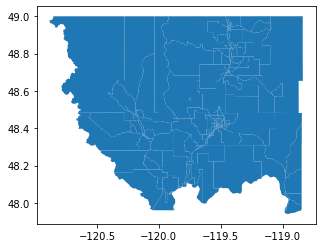

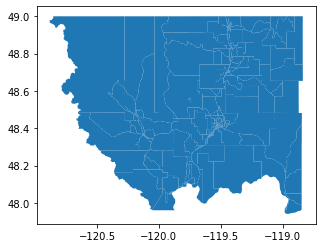

In [101]:
okdf[okdf["CountyCd"] == "OK"].plot()
sdf[sdf["CountyCd"] == "OK"].plot()

In [102]:
# This cell confirms that when a precinct has suffix "C", the county code is transformed to "OKC". 
odf = okdf[okdf["CountyCd"] == "OK"]
odf.head()
data = zip(odf["FullPrc"].unique(), odf["PrcCode"].unique())
combined_precincts = [(a, b) for a, b in data if b.endswith("C")]
print(combined_precincts)
fullprcs = [elem[0] for elem in combined_precincts]

print("VEST vote totals for combined counties")
display(vdf[vdf["FULLPRC"].isin(fullprcs)])

v_prcs = vdf["PRCCODE"].to_numpy()
v_dem = vdf["G18USSDCAN"].to_numpy()
v_rep = vdf["G18USSRHUT"].to_numpy()
prc2votes = {prc: (dem, rep) for prc, dem, rep in zip(v_prcs, v_dem, v_rep)}
print(type(prc2votes))

[('OKC0000017', '17C'), ('OKC0000179', '179C'), ('OKC0000187', '187C'), ('OKC0000200', '200C'), ('OKC0000225', '225C'), ('OKC0000025', '25C'), ('OKC0000028', '28C'), ('OKC0000031', '31C'), ('OKC0000004', '4C'), ('OKC0000073', '73C')]
VEST vote totals for combined counties


,COUNTYCD,PRCCODE,FULLPRC,G18USSDCAN,G18USSRHUT,geometry
3759,OK,17C,OKC0000017,25,33,"POLYGON ((-119.56307 48.37627, -119.56358 48.3..."
3769,OK,179C,OKC0000179,28,35,"POLYGON ((-119.71114 48.11651, -119.71134 48.1..."
3778,OK,187C,OKC0000187,20,32,"POLYGON ((-119.50590 48.41110, -119.50560 48.4..."
3794,OK,200C,OKC0000200,23,59,"POLYGON ((-119.61099 48.36451, -119.61013 48.3..."
3820,OK,225C,OKC0000225,12,23,"POLYGON ((-119.54709 48.39228, -119.54731 48.3..."
3829,OK,25C,OKC0000025,22,92,"POLYGON ((-119.64430 48.26633, -119.62243 48.2..."
3831,OK,28C,OKC0000028,38,98,"POLYGON ((-119.51690 49.00010, -119.49554 48.9..."
3843,OK,31C,OKC0000031,100,340,"POLYGON ((-119.48534 48.67011, -119.48519 48.6..."
3851,OK,4C,OKC0000004,187,422,"POLYGON ((-119.07575 49.00009, -119.05372 49.0..."
3883,OK,73C,OKC0000073,19,41,"POLYGON ((-119.53165 48.39523, -119.53182 48.3..."


<class 'dict'>


In [103]:
# Ok pause, you are getting a bit aimless

# Right now, you know that the shapefile has some precinct codes that end with "C", representing consolidated

# VEST has these same "C" precinct codes, and changes the FULLPRC to begin with "OKC" for these codes

# However, the election results do not make these "C" changes, and there might be some combining that happens behind the scenes

# We need to:
    # See which election OK precincts are not present in VEST/shape
print("These precincts are in the election file but not the vest file")
in_e_not_v = edf[~edf["PrecinctCode"].astype('str').isin(vdf["PRCCODE"].astype('str'))]
display(in_e_not_v)

print("These precincts are in the vest file but not the election file")
in_v_not_e = vdf[~vdf["PRCCODE"].astype('str').isin(edf["PrecinctCode"].astype('str'))]
display(in_v_not_e)
    # See how the vote totals of VEST compare to these election precincts that weren't included
    
election_votes = edf["Votes"].astype('int').sum()
vest_votes = vdf["G18USSDCAN"].astype('int').sum() + vdf["G18USSRHUT"].astype('int').sum()
print("Comparison of vote totals", election_votes, vest_votes)

    # Perhaps search for new SoS data that uses the consolidated precincts?

    # Transfer that work to the other notebook


These precincts are in the election file but not the vest file


,Race,CountyCode,Candidate,PrecinctName,PrecinctCode,Votes
3472,U.S. Senator,OK,Maria Cantwell,BODIE,4,7
3473,U.S. Senator,OK,Susan Hutchison,BODIE,4,15
3482,U.S. Senator,OK,Maria Cantwell,CHESAW,9,18
3483,U.S. Senator,OK,Susan Hutchison,CHESAW,9,41
3498,U.S. Senator,OK,Maria Cantwell,ELMWAY,17,25
3499,U.S. Senator,OK,Susan Hutchison,ELMWAY,17,33
3514,U.S. Senator,OK,Maria Cantwell,MONSE #1,25,22
3515,U.S. Senator,OK,Susan Hutchison,MONSE #1,25,92
3522,U.S. Senator,OK,Maria Cantwell,PINE CREEK(*),31,0
3523,U.S. Senator,OK,Susan Hutchison,PINE CREEK(*),31,0


These precincts are in the vest file but not the election file


,COUNTYCD,PRCCODE,FULLPRC,G18USSDCAN,G18USSRHUT,geometry
3759,OK,17C,OKC0000017,25,33,"POLYGON ((-119.56307 48.37627, -119.56358 48.3..."
3769,OK,179C,OKC0000179,28,35,"POLYGON ((-119.71114 48.11651, -119.71134 48.1..."
3778,OK,187C,OKC0000187,20,32,"POLYGON ((-119.50590 48.41110, -119.50560 48.4..."
3794,OK,200C,OKC0000200,23,59,"POLYGON ((-119.61099 48.36451, -119.61013 48.3..."
3820,OK,225C,OKC0000225,12,23,"POLYGON ((-119.54709 48.39228, -119.54731 48.3..."
3822,OK,229,OK00000229,0,0,"POLYGON ((-119.46519 48.72690, -119.46429 48.7..."
3824,OK,231,OK00000231,0,0,"POLYGON ((-119.51227 48.41859, -119.51227 48.4..."
3825,OK,234,OK00000234,0,0,"POLYGON ((-120.17638 48.46812, -120.17639 48.4..."
3829,OK,25C,OKC0000025,22,92,"POLYGON ((-119.64430 48.26633, -119.62243 48.2..."
3831,OK,28C,OKC0000028,38,98,"POLYGON ((-119.51690 49.00010, -119.49554 48.9..."


Comparison of vote totals 16518 16645


In [112]:
# okay step 1, create a dictionary to rename fullprcs that are equal
new_names = {
    "17" : "17C",
    "179" : "179C",
    "187" : "187C",
    "200" : "200C",
    "225" : "225C",
    "200" : "200C",
    "25" : "25C",
    "212" : "73C",
 }

rename = lambda x: new_names[x] if x in new_names else x
edf["PrecinctCode"] = edf["PrecinctCode"].astype('str').apply(rename)

print("These precincts are in the election file but not the vest file")
in_e_not_v = edf[~edf["PrecinctCode"].astype('str').isin(vdf["PRCCODE"].astype('str'))]
display(in_e_not_v)

print("These precincts are in the vest file but not the election file")
in_v_not_e = vdf[~vdf["PRCCODE"].astype('str').isin(edf["PrecinctCode"].astype('str'))]
display(in_v_not_e)
    # See how the vote totals of VEST compare to these election precincts that weren't included
    
election_votes = in_e_not_v["Votes"].astype('int').sum()
vest_votes = in_v_not_e["G18USSDCAN"].astype('int').sum() + in_v_not_e["G18USSRHUT"].astype('int').sum()
print("Comparison of vote totals", election_votes, vest_votes)
print(f"Vest has {vest_votes - election_votes} more votes, check that this matched total obfuscated votes")

These precincts are in the election file but not the vest file


,Race,CountyCode,Candidate,PrecinctName,PrecinctCode,Votes
3472,U.S. Senator,OK,Maria Cantwell,BODIE,4,7
3473,U.S. Senator,OK,Susan Hutchison,BODIE,4,15
3482,U.S. Senator,OK,Maria Cantwell,CHESAW,9,18
3483,U.S. Senator,OK,Susan Hutchison,CHESAW,9,41
3522,U.S. Senator,OK,Maria Cantwell,PINE CREEK(*),31,0
3523,U.S. Senator,OK,Susan Hutchison,PINE CREEK(*),31,0
3526,U.S. Senator,OK,Maria Cantwell,RIVERSIDE RURAL,33,23
3527,U.S. Senator,OK,Susan Hutchison,RIVERSIDE RURAL,33,88
3528,U.S. Senator,OK,Maria Cantwell,SAN POIL,34,53
3529,U.S. Senator,OK,Susan Hutchison,SAN POIL,34,70


These precincts are in the vest file but not the election file


,COUNTYCD,PRCCODE,FULLPRC,G18USSDCAN,G18USSRHUT,geometry
3822,OK,229,OK00000229,0,0,"POLYGON ((-119.46519 48.72690, -119.46429 48.7..."
3824,OK,231,OK00000231,0,0,"POLYGON ((-119.51227 48.41859, -119.51227 48.4..."
3825,OK,234,OK00000234,0,0,"POLYGON ((-120.17638 48.46812, -120.17639 48.4..."
3831,OK,28C,OKC0000028,38,98,"POLYGON ((-119.51690 49.00010, -119.49554 48.9..."
3835,OK,301,OK00000301,0,0,"POLYGON ((-119.60661 48.35410, -119.60840 48.3..."
3836,OK,303,OK00000303,0,0,"POLYGON ((-119.47893 48.44322, -119.47893 48.4..."
3837,OK,304,OK00000304,0,0,"POLYGON ((-119.55797 48.38827, -119.55706 48.3..."
3838,OK,305,OK00000305,0,0,"POLYGON ((-119.52303 48.45317, -119.52298 48.4..."
3839,OK,306,OK00000306,0,0,"POLYGON ((-119.52536 48.41874, -119.52550 48.4..."
3840,OK,307,OK00000307,0,0,"POLYGON ((-120.09562 48.35223, -120.09542 48.3..."


Comparison of vote totals 1145 1185
Vest has 40 more votes, check that this matched total obfuscated votes


In [113]:
in_e_not_v = edf[~edf["PrecinctCode"].astype('str').isin(vdf["PRCCODE"].astype('str'))]
in_e_not_v = pd.pivot_table(in_e_not_v, index="PrecinctCode", columns="Candidate", values="Votes", aggfunc="first") 
in_e_not_v.reset_index(inplace=True)

# e_prcs = "OK" + in_e_not_v["PrecinctCode"].astype('str').str.rjust(8, "0")
prcs_in_4 = ["9", "96", "4", "55", "41", "100", "34", "74", "48"]
prcs_in_4 = {old : "4C" for old in prcs_in_4}
rename_4 = lambda x: prcs_in_4[x] if x in prcs_in_4 else x

prcs_in_31 = ["9", "96", "4", "55", "41", "100", "34", "74", "48"]
prcs_in_31 = {old : "31C" for old in prcs_in_4}
rename_31 = lambda x: prcs_in_31[x] if x in prcs_in_31 else x

in_e_not_v["PrecinctCode"] = in_e_not_v["PrecinctCode"].astype('str').apply(rename_4)
agg_functions = {"PrecinctCode" : "first", "Maria Cantwell" : "sum", "Susan Hutchison" : "sum"}
in_e_not_v = in_e_not_v.groupby("PrecinctCode").aggregate(agg_functions)

display(in_e_not_v)
display(in_v_not_e)

,PrecinctCode,Maria Cantwell,Susan Hutchison
PrecinctCode,,,
139,139,14,57
151,151,20,59
31,31,0,0
33,33,23,88
4C,4C,187,422
50,50,27,79
69,69,24,41
70,70,16,44
89,89,13,31


,COUNTYCD,PRCCODE,FULLPRC,G18USSDCAN,G18USSRHUT,geometry
3822,OK,229,OK00000229,0,0,"POLYGON ((-119.46519 48.72690, -119.46429 48.7..."
3824,OK,231,OK00000231,0,0,"POLYGON ((-119.51227 48.41859, -119.51227 48.4..."
3825,OK,234,OK00000234,0,0,"POLYGON ((-120.17638 48.46812, -120.17639 48.4..."
3831,OK,28C,OKC0000028,38,98,"POLYGON ((-119.51690 49.00010, -119.49554 48.9..."
3835,OK,301,OK00000301,0,0,"POLYGON ((-119.60661 48.35410, -119.60840 48.3..."
3836,OK,303,OK00000303,0,0,"POLYGON ((-119.47893 48.44322, -119.47893 48.4..."
3837,OK,304,OK00000304,0,0,"POLYGON ((-119.55797 48.38827, -119.55706 48.3..."
3838,OK,305,OK00000305,0,0,"POLYGON ((-119.52303 48.45317, -119.52298 48.4..."
3839,OK,306,OK00000306,0,0,"POLYGON ((-119.52536 48.41874, -119.52550 48.4..."
3840,OK,307,OK00000307,0,0,"POLYGON ((-120.09562 48.35223, -120.09542 48.3..."


<AxesSubplot:>

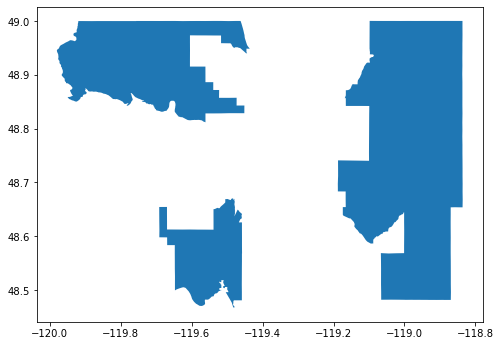

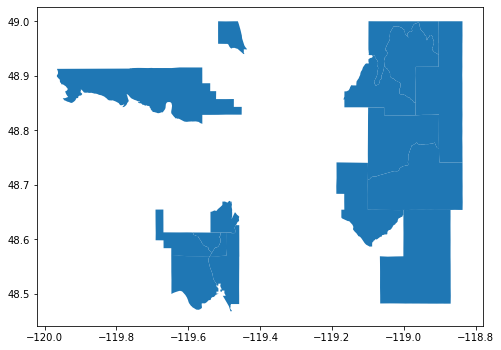

In [106]:
in_v_not_e[in_v_not_e["G18USSDCAN"] != 0].plot(figsize=(8,8))
sdf[sdf["FullPrc"].isin(e_prcs)].plot(figsize=(8,8))

In [107]:
# Let's see if the non-consolidated shapefiles in shape df fit within the merged files in consolidated, maybe then 
# we can get a mapping from one to the other
print(type(sdf), type(okdf))
display(sdf)
display(okdf)
    
in_s_not_ok = sdf[~sdf["FullPrc"].isin(okdf["FullPrc"])]
display(in_s_not_ok)

in_ok_not_s = okdf[~okdf["FullPrc"].isin(sdf["FullPrc"])]
display(in_ok_not_s)


<class 'geopandas.geodataframe.GeoDataFrame'> <class 'geopandas.geodataframe.GeoDataFrame'>


,CountyCd,PrcCode,FullPrc,geometry
4258,OK,1,OK00000001,"POLYGON ((-119.60900 48.32471, -119.61077 48.3..."
4259,OK,10,OK00000010,"POLYGON ((-119.90152 48.69690, -119.89953 48.6..."
4260,OK,100,OK00000100,"POLYGON ((-119.03249 48.82746, -119.03390 48.8..."
4261,OK,101,OK00000101,"POLYGON ((-118.97403 47.96683, -118.97445 47.9..."
4262,OK,102,OK00000102,"POLYGON ((-118.96243 47.97714, -118.96243 47.9..."
...,...,...,...,...
4501,OK,95,OK00000095,"POLYGON ((-119.44166 48.96440, -119.44148 48.9..."
4502,OK,96,OK00000096,"POLYGON ((-118.90268 48.93833, -118.90285 48.9..."
4503,OK,97,OK00000097,"POLYGON ((-119.34216 48.97378, -119.34228 48.9..."
4504,OK,98,OK00000098,"POLYGON ((-119.44523 48.89961, -119.44525 48.9..."


,CountyCd,PrcCode,FullPrc,geometry
4258,OK,1,OK00000001,"POLYGON ((-119.60900 48.32471, -119.61077 48.3..."
4259,OK,10,OK00000010,"POLYGON ((-119.90152 48.69690, -119.89953 48.6..."
4260,OK,101,OK00000101,"POLYGON ((-118.97403 47.96683, -118.97445 47.9..."
4261,OK,102,OK00000102,"POLYGON ((-118.96243 47.97714, -118.96243 47.9..."
4262,OK,103,OK00000103,"POLYGON ((-118.96983 47.97154, -118.96987 47.9..."
...,...,...,...,...
4476,OK,94,OK00000094,"POLYGON ((-120.15945 48.49605, -120.15586 48.4..."
4477,OK,95,OK00000095,"POLYGON ((-119.44166 48.96440, -119.44148 48.9..."
4478,OK,97,OK00000097,"POLYGON ((-119.34216 48.97378, -119.34228 48.9..."
4479,OK,98,OK00000098,"POLYGON ((-119.44523 48.89961, -119.44525 48.9..."


,CountyCd,PrcCode,FullPrc,geometry
4260,OK,100,OK00000100,"POLYGON ((-119.03249 48.82746, -119.03390 48.8..."
4302,OK,139,OK00000139,"POLYGON ((-119.49110 48.95862, -119.49505 48.9..."
4316,OK,151,OK00000151,"POLYGON ((-119.47005 48.61880, -119.46953 48.6..."
4336,OK,17,OK00000017,"POLYGON ((-119.55190 48.38314, -119.55312 48.3..."
4346,OK,179,OK00000179,"POLYGON ((-119.71138 48.10562, -119.71155 48.1..."
4355,OK,187,OK00000187,"POLYGON ((-119.51217 48.40477, -119.51250 48.4..."
4371,OK,200,OK00000200,"POLYGON ((-119.59755 48.35558, -119.59764 48.3..."
4384,OK,212,OK00000212,"POLYGON ((-119.54090 48.39945, -119.53945 48.3..."
4398,OK,225,OK00000225,"POLYGON ((-119.55190 48.38314, -119.55258 48.3..."
4400,OK,227,OK00000227,"POLYGON ((-119.55480 48.36408, -119.55478 48.3..."


,CountyCd,PrcCode,FullPrc,geometry
4333,OK,17C,OKC0000017,"POLYGON ((-119.56307 48.37627, -119.56358 48.3..."
4343,OK,179C,OKC0000179,"POLYGON ((-119.71114 48.11651, -119.71134 48.1..."
4352,OK,187C,OKC0000187,"POLYGON ((-119.50590 48.41110, -119.50560 48.4..."
4368,OK,200C,OKC0000200,"POLYGON ((-119.61099 48.36451, -119.61013 48.3..."
4394,OK,225C,OKC0000225,"POLYGON ((-119.54709 48.39228, -119.54731 48.3..."
4403,OK,25C,OKC0000025,"POLYGON ((-119.64430 48.26633, -119.62243 48.2..."
4405,OK,28C,OKC0000028,"POLYGON ((-119.51690 49.00010, -119.49554 48.9..."
4417,OK,31C,OKC0000031,"POLYGON ((-119.48534 48.67011, -119.48519 48.6..."
4425,OK,4C,OKC0000004,"POLYGON ((-119.07575 49.00009, -119.05372 49.0..."
4457,OK,73C,OKC0000073,"POLYGON ((-119.53165 48.39523, -119.53182 48.3..."


In [108]:
# Let's use the "within" function to get a mapping 
for prc1 in in_ok_not_s["FullPrc"]:
    curr1 = in_ok_not_s[in_ok_not_s["FullPrc"] == prc1]
    for prc2 in in_s_not_ok["FullPrc"]:
        curr2 = in_s_not_ok[in_s_not_ok["FullPrc"] == prc2]
